In [274]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import math
from operator import add

In [275]:
pruning_amounts = []
accuracies = []
comp_time = []
model_size = []
with open('pruning_results.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        
        pruning_amounts.append(float(row[0].replace('%', '')))
        accuracies.append(float(row[1].replace('%', '')))
        comp_time.append(float(row[2]))
        model_size.append(float(row[3]))


In [276]:
print(f"len accuracies: {len(accuracies)}, len comp_time: {len(comp_time)}, len model_size: {len(model_size)}")

len accuracies: 120, len comp_time: 120, len model_size: 120


In [277]:
def get_accuracy_reward(accuracy_new,  accuracy_min):
    if accuracy_new > (accuracy_min - 10**-3) and accuracy_new < (accuracy_min + 10**-3):
        return 10000.0
    elif accuracy_new > (accuracy_min + 10**-3):
        return (accuracy_new - accuracy_min)*100
    else:
        return (accuracy_min - accuracy_new)*-10000.0

def get_model_size_reward(model_size_new,  model_size_min):
    delta_model_size = model_size_new - model_size_min
    if delta_model_size < 0:
        return 100*delta_model_size
    else:
        return 300 * delta_model_size

def get_comp_time_reward(comp_time_new,  comp_time_min):
    delta_comp_time = comp_time_new - comp_time_min
    return 100*delta_comp_time if delta_comp_time < 0 else 300 * delta_comp_time

def reward_func(accuracy,  model_size,  comp_time,  accuracy_min,  model_size_min,  comp_time_min,  x=1,  y=1,  z=1):
    accuracy_reward = get_accuracy_reward(accuracy,  accuracy_min)
    model_size_reward = get_model_size_reward(model_size,  model_size_min)
    comp_time_reward = get_comp_time_reward(comp_time,  comp_time_min)
    # print(accuracy_reward,  model_size_reward,  comp_time_reward)
    return x*accuracy_reward + y*model_size_reward + z*comp_time_reward

In [278]:
old_model_size,  old_comp_time = model_size[0],  comp_time[0]
ACC_MIN = 40.0
#HYPERPARAMS
ACCURACY_IMP = 0.6
MODEL_SIZE_IMP = 0.4
COMP_TIME_IMP = 0.0

if np.ceil(ACCURACY_IMP + MODEL_SIZE_IMP + COMP_TIME_IMP) != 1:
    print("Sum of hyperparameters = ",  ACCURACY_IMP + MODEL_SIZE_IMP + COMP_TIME_IMP)
    raise ValueError ("Hyperparameters are not correct")
    
print("Original Accuracy",  accuracies[0])

print(f"Hyperparameters: ACCURACY_IMP: {ACCURACY_IMP}, MODEL_SIZE_IMP: {MODEL_SIZE_IMP}, COMP_TIME_IMP: {COMP_TIME_IMP}")

rewards = []

for i in range(0,  len(accuracies)):
    reward = reward_func(accuracies[i],  model_size[i],  comp_time[i],  ACC_MIN,  
                         old_model_size,  old_comp_time,  ACCURACY_IMP,  MODEL_SIZE_IMP,  COMP_TIME_IMP)
    # print(f"Pruning amount: {pruning_amounts[i]},  Reward: {reward}")
    rewards.append(reward)
    old_model_size,  old_comp_time = model_size[i],  comp_time[i]

Original Accuracy 53.2
Hyperparameters: ACCURACY_IMP: 0.6, MODEL_SIZE_IMP: 0.4, COMP_TIME_IMP: 0.0


In [279]:
max(rewards)

8637.149505615234

In [280]:
index_max = np.argmax(rewards)
print(f"Max reward: {rewards[index_max]},  Pruning amount: {pruning_amounts[index_max]}")

Max reward: 8637.149505615234,  Pruning amount: 23.5


In [281]:
def normalize(lst: list) -> list:
    min_val = min(lst)
    max_val = max(lst)
    return ([(x - min_val) / (max_val - min_val) if max_val != min_val else 0 for x in lst])

In [282]:
normalized_rewards = normalize(rewards)

In [283]:
sum(comp_time)/len(comp_time)

0.10532490015029908

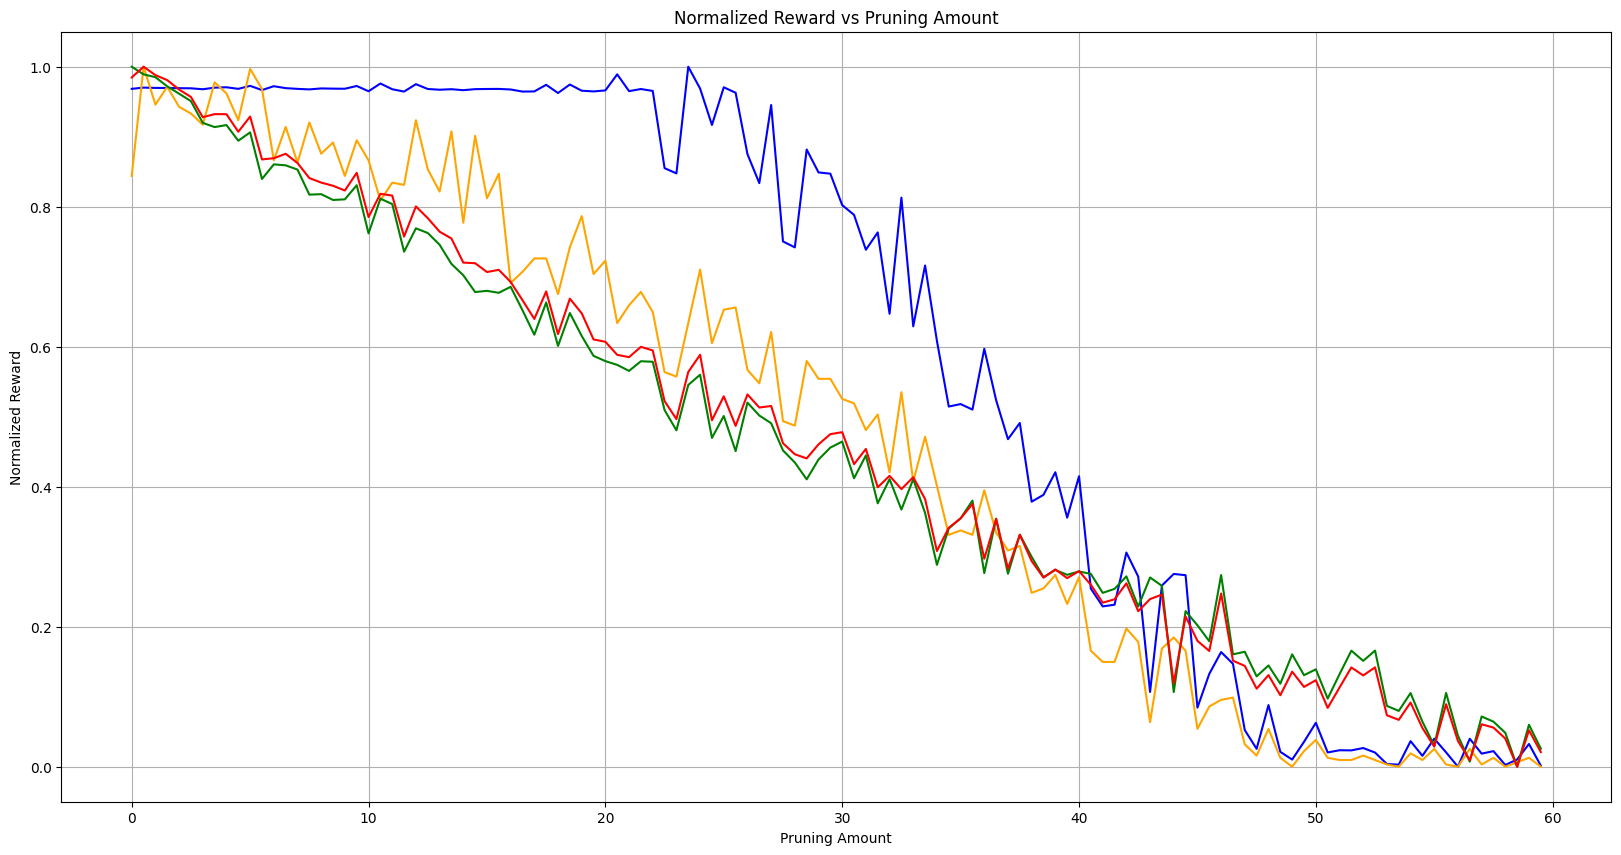

In [284]:
import matplotlib.pyplot as plt
plt.plot(pruning_amounts, normalized_rewards,  label='Reward',  color='blue')
plt.plot(pruning_amounts, normalize(accuracies),  label='Accuracy',  color='orange')
plt.plot(pruning_amounts, normalize(model_size),  label='Model Size',  color='green')
# plt.plot(pruning_amounts, normalize(comp_time),  label='Comp Time',  color='red')
plt.plot(pruning_amounts, normalize(list(map(add, accuracies, model_size))), label='Comp Time',  color='red')
plt.xlabel('Pruning Amount')
plt.ylabel('Normalized Reward')
plt.title('Normalized Reward vs Pruning Amount')
plt.grid()
figsize = plt.gcf()
figsize.set_size_inches(20, 10)
plt.show()

In [285]:
def add_pruning_data(pruning_amounts, accuracy, comp_time, model_size, step=0.1, window_size=10, poly_order=9, noise=1.0):
    df = pd.DataFrame({'pruning': pruning_amounts, 'accuracy': accuracy, 'comp_time': comp_time, 'model_size': model_size})
    
    new_pruning_amounts = np.arange(0, np.max(pruning_amounts) + step, step)
    df_interp = df.set_index('pruning').reindex(new_pruning_amounts).interpolate(method='linear')
    
    # Apply Savitzky-Golay filter for smoothing
    def smooth_series(series):
        return savgol_filter(series, window_size, poly_order, mode='nearest') if len(series) > window_size else series
    
    df_interp['accuracy_smooth'] = smooth_series(df_interp['accuracy'].values)
    df_interp['model_size_smooth'] = smooth_series(df_interp['model_size'].values)
    df_interp['comp_time_smooth'] = smooth_series(df_interp['comp_time'].values)
    
    # Add noise if specified
    if noise != 0.0:
        new_acc = smooth_series(df_interp['accuracy_smooth'].values) + np.random.normal(scale=noise, size=len(df_interp))
        new_comp = smooth_series(df_interp['comp_time_smooth'].values) + np.random.normal(scale=noise, size=len(df_interp))
        new_size = smooth_series(df_interp['model_size_smooth'].values) + np.random.normal(scale=noise, size=len(df_interp))
        return new_pruning_amounts, new_acc, new_comp, new_size
    else:
        return new_pruning_amounts, df_interp['accuracy_smooth'].values, df_interp['comp_time_smooth'].values, df_interp['model_size_smooth'].values

In [286]:
new_pruning, new_acc, new_comp, new_size = add_pruning_data(
    np.array(pruning_amounts), \
    np.array(accuracies), 
    np.array(comp_time), 
    np.array(model_size), 
    step=0.1,
    window_size=5,
    poly_order=3,
    noise=1e-10
)
print(f"pruning {len(new_pruning)}, accuracy {len(new_acc)}, comp_time {len(new_comp)}, model_size {len(new_size)}")

pruning 596, accuracy 596, comp_time 596, model_size 596


In [287]:
rewards = []
old_model_size, old_comp_time = new_size[0], new_comp[0]

for i in range(len(new_pruning)):
    reward = reward_func(
        accuracy=abs(new_acc[i]), model_size=new_size[i], comp_time=new_comp[i], accuracy_min=ACC_MIN,
        model_size_min=old_model_size, comp_time_min=old_comp_time, 
        x=ACCURACY_IMP, y=COMP_TIME_IMP, z=MODEL_SIZE_IMP
    )
    rewards.append(float(math.tan(reward)))

In [288]:
def save_to_csv(pruning_amounts, accuracies, comp_time, model_size, rewards, norm_rewards):
    with open('pruning_results_extra_steps.csv', 'w') as file:
        file.write("Pruning amount, Accuracy, Comp time, Model size, Reward, Norm Reward\n")
        for i in range(len(pruning_amounts)):
            data = f"{pruning_amounts[i]}, {accuracies[i]}, {comp_time[i]}, {model_size[i]}, {rewards[i]}, {norm_rewards[i]}\n"
            file.write(data)

In [289]:
#print max reward
index_max = np.argmax(rewards)
print(f"Max reward: {rewards[index_max]},  Pruning amount: {new_pruning[index_max]}")
print(f"Accuracy at max reward: {new_acc[index_max]},  Comp time: {new_comp[index_max]},  Model size: {new_size[index_max]}")


Max reward: 96.1925626781344,  Pruning amount: 58.5
Accuracy at max reward: 0.5999999999258558,  Comp time: 0.09314451214922274,  Model size: 190.20438950213298


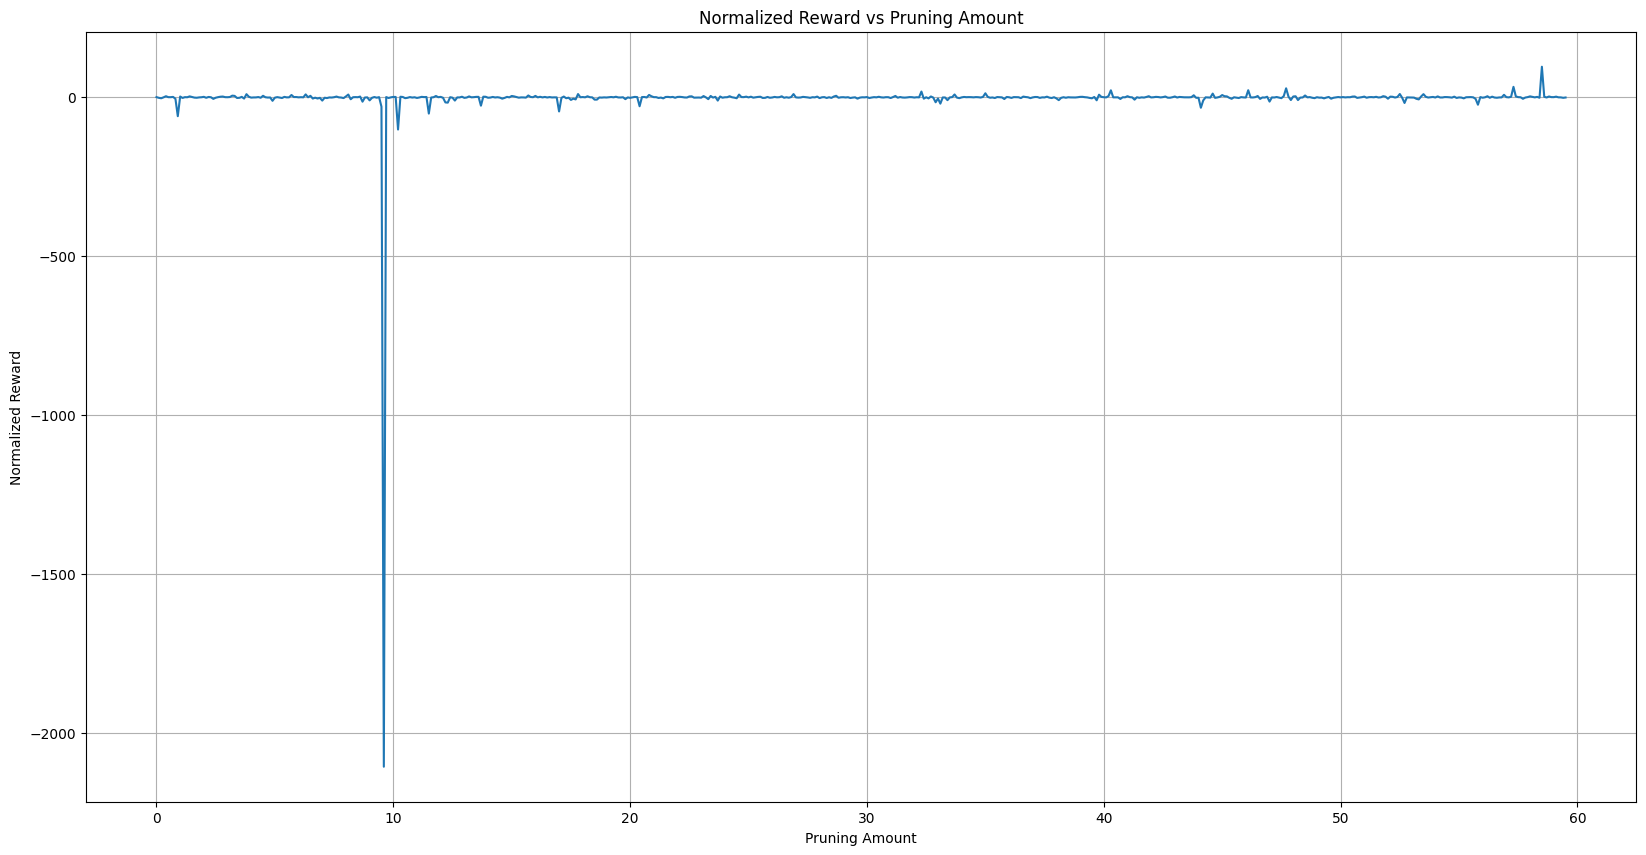

In [290]:
#plot norm_rewards
import matplotlib.pyplot as plt
plt.plot(new_pruning, rewards)
plt.xlabel('Pruning Amount')
plt.ylabel('Normalized Reward')
plt.title('Normalized Reward vs Pruning Amount')
plt.grid()
figsize = plt.gcf()
figsize.set_size_inches(20, 10)
plt.show()